In [1]:
import importlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyswarms.utils.plotters import plot_cost_history
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import src.SI as SI
importlib.reload(SI)

<module 'src.SI' from 'c:\\Users\\seppe\\OneDrive\\Desktop\\Cursussen\\Big Data Algorithms\\Project\\BDA-project\\notebooks\\src\\SI.py'>

## Data

In [16]:
data_points = pd.read_csv('data/iris/iris.txt', sep=',', header=None)
labels = data_points[4].values
data_points = data_points.drop([4], axis=1)

label_map = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}
numeric_labels = np.vectorize(label_map.get)(labels).astype(np.int32)

## Clustering

In [17]:
input_data = data_points
true_labels = numeric_labels
n_clusters = 3

results = pd.DataFrame(columns=['Accuracy Score', "Adjusted Rand Score", "Silhouette Score"])

In [18]:
# Code to translate arbitrary predicted labels to match ground truth labels
from munkres import Munkres

def make_cost_matrix(c1, c2):
    uc1, uc2 = np.unique(c1), np.unique(c2)
    assert uc1.size == uc2.size and np.all(uc1 == uc2)

    m = np.ones([uc1.size, uc2.size])
    for i, val_i in enumerate(uc1):
        it_i = np.nonzero(c1 == val_i)[0]
        for j, val_j in enumerate(uc2):
            it_j = np.nonzero(c2 == val_j)[0]
            m[i, j] = -np.intersect1d(it_i, it_j).size
    return m

def translate_predicted_labels(predicted_y, y):
    cost_matrix = make_cost_matrix(predicted_y, y)
    indexes = Munkres().compute(cost_matrix)
    mapper = {old: new for (old, new) in indexes}
    
    for old, new in mapper.items():
        print(f"Mapping cluster {old} → Class {new}")

    return np.array([mapper[i] for i in predicted_y])

### Old analysis

In [19]:
# Run K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(input_data)

kmeans_centers = kmeans.cluster_centers_

In [22]:
translated_kmeans_labels = translate_predicted_labels(kmeans_labels, true_labels)
results.loc["K-Means"] = SI.evaluate_labels(input_data, true_labels, translated_kmeans_labels)

Mapping cluster 0 → Class 2
Mapping cluster 1 → Class 0
Mapping cluster 2 → Class 1


### Swarm algorithms

In [33]:
iters = 1000

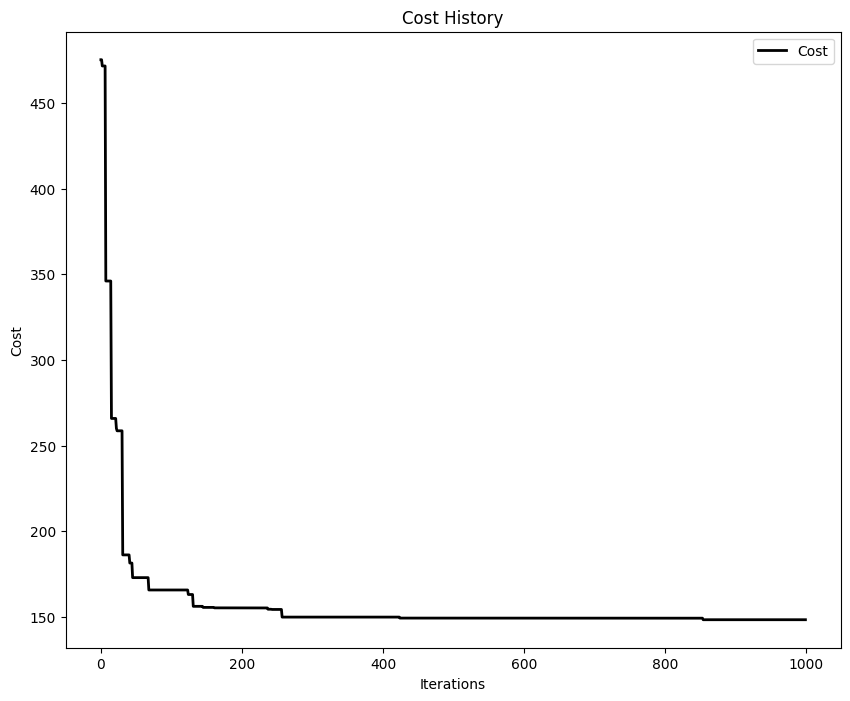

In [34]:
# Run PSO
pso_cost, pso_centers, pso_labels, pso_pos_history, pso_cost_history, pso_best_centers_history = SI.run_pso(input_data, n_clusters, iters, n_particles=30, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, record_history=True)

plot_cost_history(cost_history=pso_cost_history)
plt.show()

In [35]:
translated_pso_labels = translate_predicted_labels(pso_labels, true_labels)
results.loc["PSO"] = SI.evaluate_labels(input_data, true_labels, translated_pso_labels)

Mapping cluster 0 → Class 0
Mapping cluster 1 → Class 1
Mapping cluster 2 → Class 2


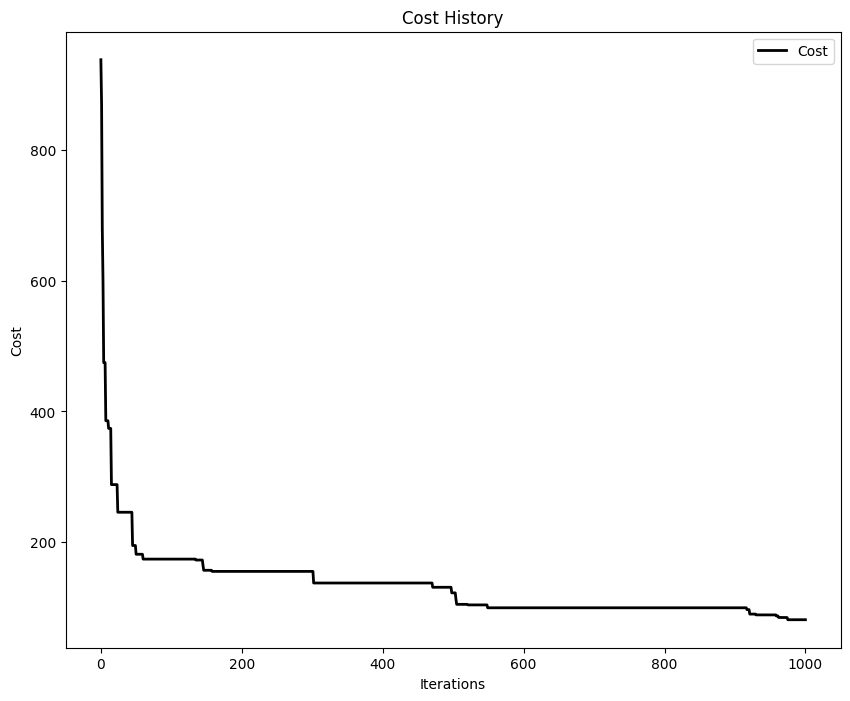

In [36]:
# Run ABC
abc_cost, abc_centers, abc_labels, abc_history = SI.run_abc(
    input_data, n_clusters=n_clusters, iters=iters, n_food_sources=30, limit=20, record_history=True
)

plot_cost_history(cost_history=abc_history["costs"])
plt.show()

In [37]:
translated_abc_labels = translate_predicted_labels(abc_labels, true_labels)
results.loc["ABC"] = SI.evaluate_labels(input_data, true_labels, translated_abc_labels)

Mapping cluster 0 → Class 0
Mapping cluster 1 → Class 2
Mapping cluster 2 → Class 1


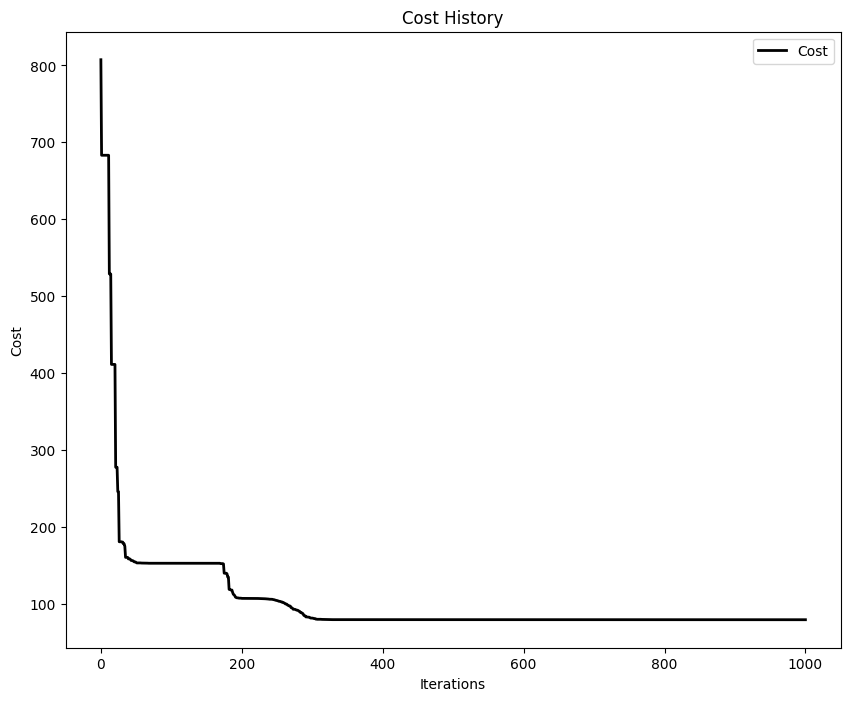

In [38]:
# Run ACOR (ACO variant)
acor_cost, acor_centers, acor_labels, acor_history = SI.run_acor(
    input_data, n_clusters=n_clusters, iters=iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)

plot_cost_history(cost_history=acor_history["costs"])
plt.show()

In [39]:
translated_acor_labels = translate_predicted_labels(acor_labels, true_labels)
results.loc["ACOR"] = SI.evaluate_labels(input_data, true_labels, translated_acor_labels)

Mapping cluster 0 → Class 1
Mapping cluster 1 → Class 2
Mapping cluster 2 → Class 0


## Results

In [40]:
results.head()

,Accuracy Score,Adjusted Rand Score,Silhouette Score
K-Means,0.887,0.716,0.551
PSO,0.693,0.561,0.471
ACOR,0.893,0.730,0.553
ABC,0.887,0.716,0.551
